# DRP DPDD-ification update
## Tuesday Nov 6 2018

This notebook demos DRP's prototype tools to transform the science pipelines output into standardized tables ready for ingestion. In context of Gregory's sketch from the SST meeting on 11/05/2018, this provides detail for the red "Standardization" and "Object Parquet" boxes. 

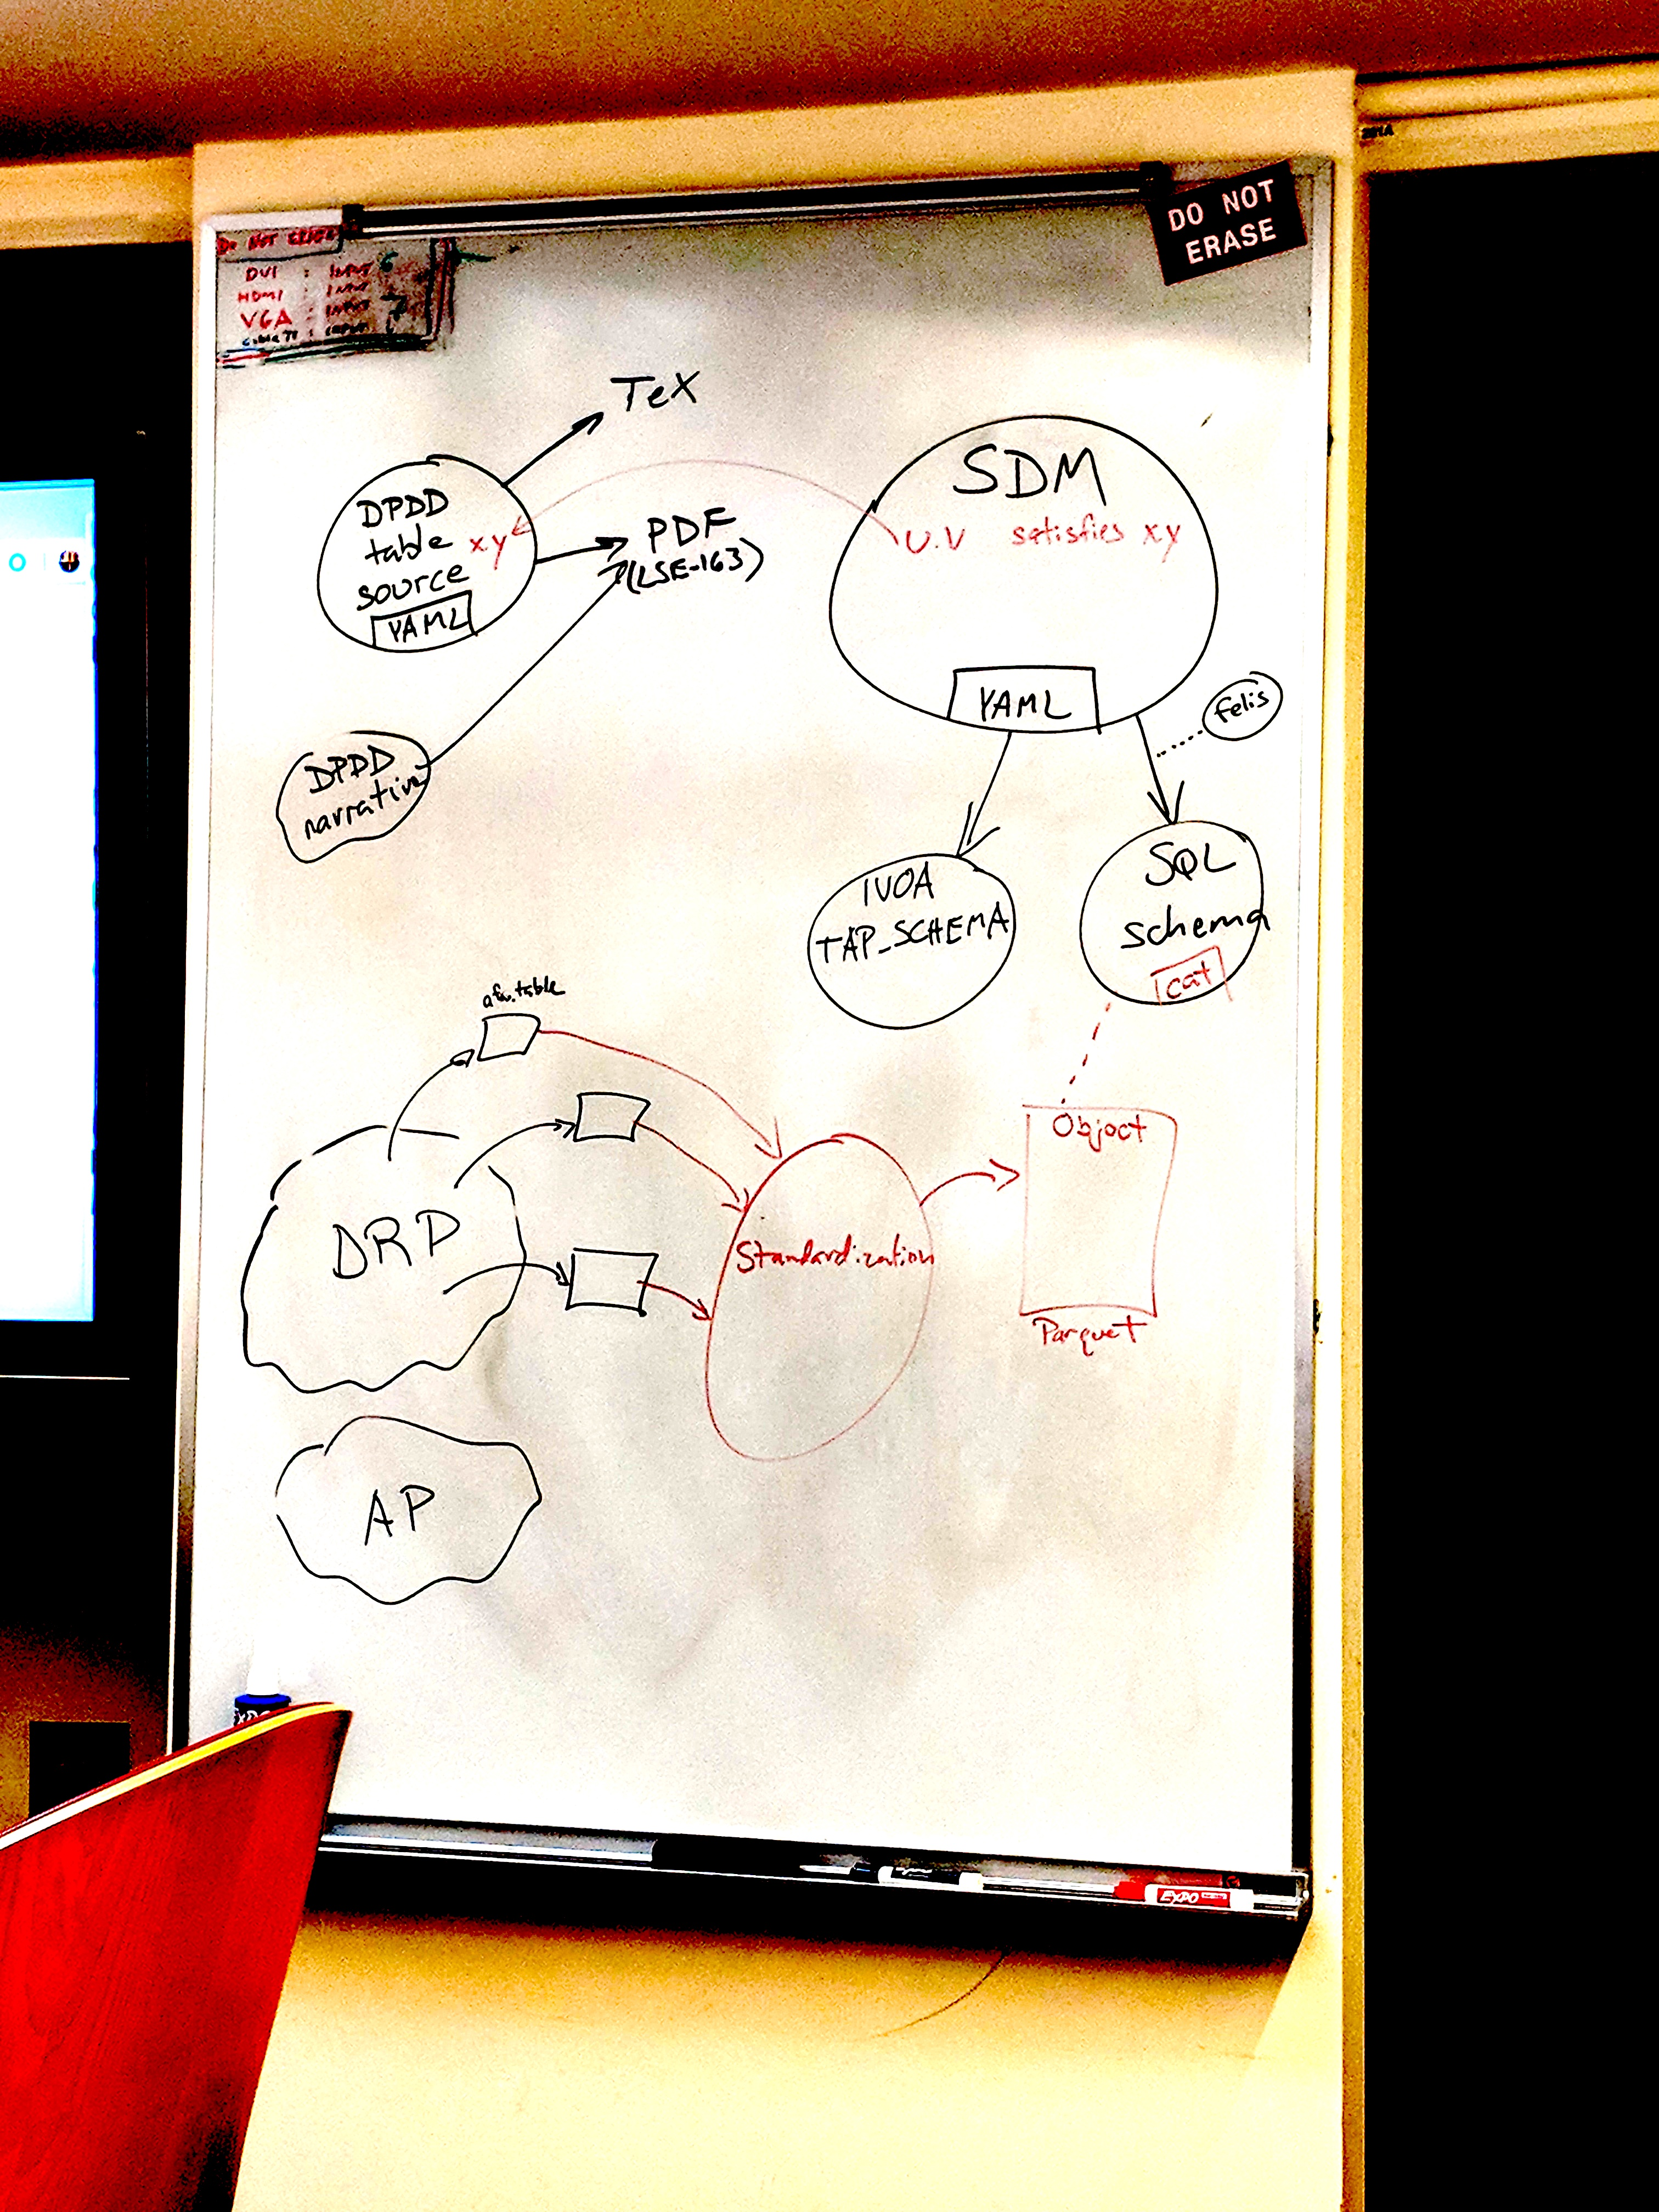

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image("/project/yusra/IMG_20181105_114925.jpg", width=500)

***
## What was the problem?

*  Came up in May 2018 when DAX tried to ingest HSC data, and it looked nothing like the data challenge data. 
* Science Pipelines produce files that need to be ETL’ed and ingested (immediately into the PDAC), but the Science Pipelines team has the expertise on transform step.
* Requirements driven by DAX, Science Pipelines, and Users (via SST)


## How did we solve this before?
#### Previous Data Challenges
* *What*: Had an ETL package called datarel: https://github.com/lsst-dm/legacy-datarel It could create a database, convert the afwTable fits to csv, bulk load the csvs, and then finalize the database defining indexes, views, etc... 
    - See our old mysql DB on lsst-db for examples. 
* *How*: Had a smaller team. Inter-DM contributions to our ingest package `datarel` https://github.com/lsst-dm/legacy-datarel/graphs/contributors

#### HSC
* *What*: Have an ETL ingestion package called db-meas-forced: https://hsc-gitlab.mtk.nao.ac.jp/sogo.mineo/db-meas-forced It uses the pipelines output and loads EVERYTHING (all 3760 columns) after applying transformations.
    * We load directly (without intermediate flat csv file for bullk loading)
    * See final product: https://hscdata.mtk.nao.ac.jp/schema_browser3/
    * Only load the equivalent of the "Object Table," vertically partitioned
    * We find all the flags and measurements useful
 
* *How*: Columns change from production run to production run. NAOJ database pro Mineo Sogo works closely with the pipeline team to adapt the package for each data release. 

# Prototype `TransformObjectCatalog`

Use prototype `CommandlineTasks` to transform the `afwTable` fits files to parquet tables with the schema requested by the DPDD. The transformations are specified in yaml.
* For now, the `Object.yaml` to specify the HSC Object table lives in https://github.com/lsst/obs_subaru/blob/master/policy/Object.yaml This will move after we normalize out the filter names. 

* The prototype  for the "Object Table" is `transformObjectCatalog`. Code currently in https://github.com/lsst-dm/qa_explorer per developement history. Tim Morton was prototyping QA tooling to visualize billions of rows of data with Parquet/Dask, and was already halfway to transforming the object catalogs

We plan to submit an RFC to move the post-processing tasks to pipe_tasks


### Overview of Commandline Tasks:
**Step 1:** Run `writeObjectTable.py` to match pipelines output and convert to parquet. **All data** is copied without transformation:
    # Inputs: deepCoadd_meas, deepCoadd_forced_src, deepCoadd_ref (see footnote for flowchart)
    # Outputs: deepCoadd_obj

    writeObjectTable.py /datasets/hsc/repo \ 
        --rerun RC/w_2018_42/DM-16095:private/yusra/RC2/w_2018_42 \ 
        --id tract=9615^9697 filter=HSC-G^HSC-R^HSC-I^HSC-Z^HSC-Y -j 8 
    
**Step 2:**  Run `transformObjectCatalog.py` to extract, transform, rename, the columns per the yaml specification.
    # Inputs: deepCoadd_obj
    # Outputs: objectTable

    transformObjectCatalog.py /datasets/hsc/repo --rerun private/yusra/RC2/w_2018_42 \ 
        --id tract=9615^9697 -j 8 --no-versions

**Step 3:** Concatenate all ObjectTables in a given tract (optional):
    # Inputs: objectTable
    # Outputs: objectTable_tract

    consolidateObjectTable.py /datasets/hsc/repo --rerun private/yusra/RC2/w_2018_42 \
        --id tract=9615^9697 --no-versions

### OUTPUTS: Per-tract Object Parquet available for loading
Access on lsst-dev:
    
    > cd /datasets/hsc/repo/rerun/private/yusra/RC2/w_2018_42
    > ls deepCoadd-results/merged/9615/objectTable-9615.parq
    > ls deepCoadd-results/merged/9697/objectTable-9697.parq

Or via the butler:

    butler = Butler("/datasets/hsc/repo/rerun/private/yusra/RC2/w_2018_42")
    butler.get("ObjectTable", tract=9813)
 

In [2]:
from lsst.daf.persistence import Butler
import lsst.qa.explorer
import lsst.qa.explorer.functors
from importlib import reload

/home/yusra/.local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# How it works
### Inputs (Part 1 of 2: Data)

`deepCoadd_obj` is a multilevel parquet file per patch created by `writeObjectTable.py`. It contains all rows, all columns, all filters.

In [3]:
butler = Butler('/datasets/hsc/repo/rerun/private/yusra/RC2/w_2018_42')
p = butler.get('deepCoadd_obj', tract=9615, patch='4,4')
p

In [4]:
#columnDict = {'dataset': 'ref', 'filter': 'HSC-G',  'column': ['parent', 'slot_PsfFlux_instFlux']}

columnDict = {'filter': ['HSC-G', 'HSC-R'], 'column': ['slot_PsfFlux_instFlux']}
df = p.toDataFrame(columns=columnDict)  # reads just the columns requested
df.tail()

dataset           forced_src                meas                 ref          
filter                 HSC-G     HSC-R     HSC-G     HSC-R     HSC-G     HSC-R
id                                                                            
42287784139988938   1.106413  0.503439  1.106413  0.709003  1.106413  1.106413
42287784139988939   1.084997  0.006611  1.084997  0.005784  1.084997  1.084997
42287784139988940   0.977499  0.166483  0.977499  0.223757  0.977499  0.977499
42287784139988941   1.282867  0.233347  1.282867  0.156379  1.282867  1.282867
42287784139988942   1.227284  0.498713  1.227284  0.463849  1.227284  1.227284

### Inputs (Part 2 of 2: Specification)

How to specify the mapping from `deepCoadd_obj` to `ObjectTable`

A draft is available in: https://github.com/lsst/obs_subaru/blob/master/policy/Object.yaml

In [5]:
%%file example.yaml

funcs:
    gPsfMag:
        functor: NanoJansky
        args: base_PsfFlux_instFlux
        filt: HSC-G
        dataset: ref
    rCModelMag: 
        functor: NanoJansky
        args: modelfit_CModel_instFlux
        filt: HSC-R
        dataset: forced_src
    rCModelMag_flag: 
        functor: Column
        args: modelfit_CModel_flag
        filt: HSC-R
        dataset: forced_src
    rBdReB:
        functor: RadiusFromQuadrupole
        dataset: meas
        filt: HSC-R
        args:
            - modelfit_CModel_dev_ellipse_xx
            - modelfit_CModel_dev_ellipse_xy
            - modelfit_CModel_dev_ellipse_yy
    rBdReD:
        functor: RadiusFromQuadrupole
        dataset: meas
        filt: HSC-R
        args:
            - modelfit_CModel_exp_ellipse_xx
            - modelfit_CModel_exp_ellipse_xy
            - modelfit_CModel_exp_ellipse_yy

Overwriting example.yaml


In [6]:
reload(lsst.qa.explorer.functors)

<module 'lsst.qa.explorer.functors' from '/home/yusra/lsst_devel/DMS/qa_explorer_local/python/lsst/qa/explorer/functors.py'>

In [7]:
funcs = lsst.qa.explorer.functors.CompositeFunctor.from_file('example.yaml')
result = funcs(p, dropna=False)
result.tail()

,gPsfMag,rBdReB,rBdReD,rCModelMag,rCModelMag_flag
id,,,,,
42287784139988938,63.667444,0.451587,1.103623,40.226025,False
42287784139988939,62.435069,2.192543,2.198707,0.377415,False
42287784139988940,56.249184,2.459113,3.049968,29.772113,False
42287784139988941,73.821304,NaN,NaN,NaN,True
42287784139988942,70.622794,NaN,NaN,NaN,True


## Outputs

In [8]:
output = butler.get('objectTable', tract=9615, patch='4,4')
output.toDataFrame().tail()

column,objectId,parentObjectId,coord_ra,coord_dec,Ra,Dec,refBand,grStd,riStd,izStd,...,yIxxPsf,yIxy,yIxyPsf,yIyy,yIyyPsf,yKronFlux,yKronFluxErr,yKronRad,yPsFlux,yPsFluxErr
id,,,,,,,,,,,,,,,,,,,,,
42287784139988938,42287784139988938,42287784139962495,216.305520,0.771640,216.305613,0.771586,g,0.698808,-0.287001,-0.829924,...,2.687581,NaN,0.047840,NaN,3.197551,689.188477,655.726749,11.833938,-18.173188,83.395880
42287784139988939,42287784139988939,42287784139962612,216.353888,0.830393,216.353996,0.830335,g,5.803122,NaN,NaN,...,2.703514,NaN,0.008203,NaN,3.120546,1168.509726,356.435281,6.942716,58.918770,77.880135
42287784139988940,42287784139988940,42287784139962612,216.353590,0.830272,216.353609,0.830275,g,1.289000,0.522815,NaN,...,2.703226,NaN,0.008043,NaN,3.121080,NaN,NaN,NaN,-36.634877,78.650947
42287784139988941,42287784139988941,42287784139962617,216.356023,0.832642,216.356036,0.832654,g,NaN,NaN,NaN,...,2.705001,NaN,0.009014,NaN,3.117287,713.924027,394.866970,7.834407,6.419486,77.423394
42287784139988942,42287784139988942,42287784139962617,216.356321,0.832643,216.356316,0.832654,g,NaN,NaN,NaN,...,2.705224,NaN,0.009123,NaN,3.116902,NaN,NaN,NaN,5.251229,77.117761


In [9]:
df = output.toDataFrame()
for row in df.iloc[0].iteritems():
    print(row)

('objectId', 42287784139948033)
('parentObjectId', 0)
('coord_ra', 216.35570663172956)
('coord_dec', 0.6460347338415463)
('Ra', 216.35570663172956)
('Dec', 0.6460347338415463)
('refBand', 'i')
('grStd', nan)
('riStd', nan)
('izStd', nan)
('zyStd', nan)
('refIxx', 1.1578840126634344)
('refIyy', 3.2383967878164244)
('refIxy', -0.1363797080138176)
('refIxxPsf', 1.6234004649940255)
('refIyyPsf', 1.9744563345706043)
('refIxyPsf', -0.08514791773299485)
('refExtendedness', nan)
('x', 16726.0)
('y', 15904.0)
('xErr', nan)
('yErr', nan)
('xy_flag', True)
('refFwhm', 0.7135897722402752)
('tractId', 9615)
('patchId', '4,4')
('detect_isPatchInner', False)
('detect_isPrimary', False)
('detect_isTractInner', True)
('PixelFlags', False)
('PixelFlags_bad', False)
('PixelFlags_bright_object', False)
('PixelFlags_bright_objectCenter', False)
('PixelFlags_clipped', False)
('PixelFlags_clippedCenter', False)
('PixelFlags_cr', False)
('PixelFlags_crCenter', False)
('PixelFlags_edge', True)
('PixelFlags_ine

# Outstanding Questions

How do we maintain the Object.yaml? Science Pipelines knows how to fulfill the required columns, but can we get a CI or unit test for an interface we have to follow. How to we request changes to the interface?

# Next Steps:
* **RFC** move of the transformation tasks and supporting classes to `pipe_tasks` and introduce as part of the biweekly RC2's
    * DM-16434 Make TransformObjectCatalogsTask more Robust
    * DM-16234 Move qa_explorer/transformObjectCatalog and writeObjectTable to pipe_tasks
    * DM-16435 Refactor qa.explorer.functors and make robust and extensible for move to pipe_tasks


## Footnotes:

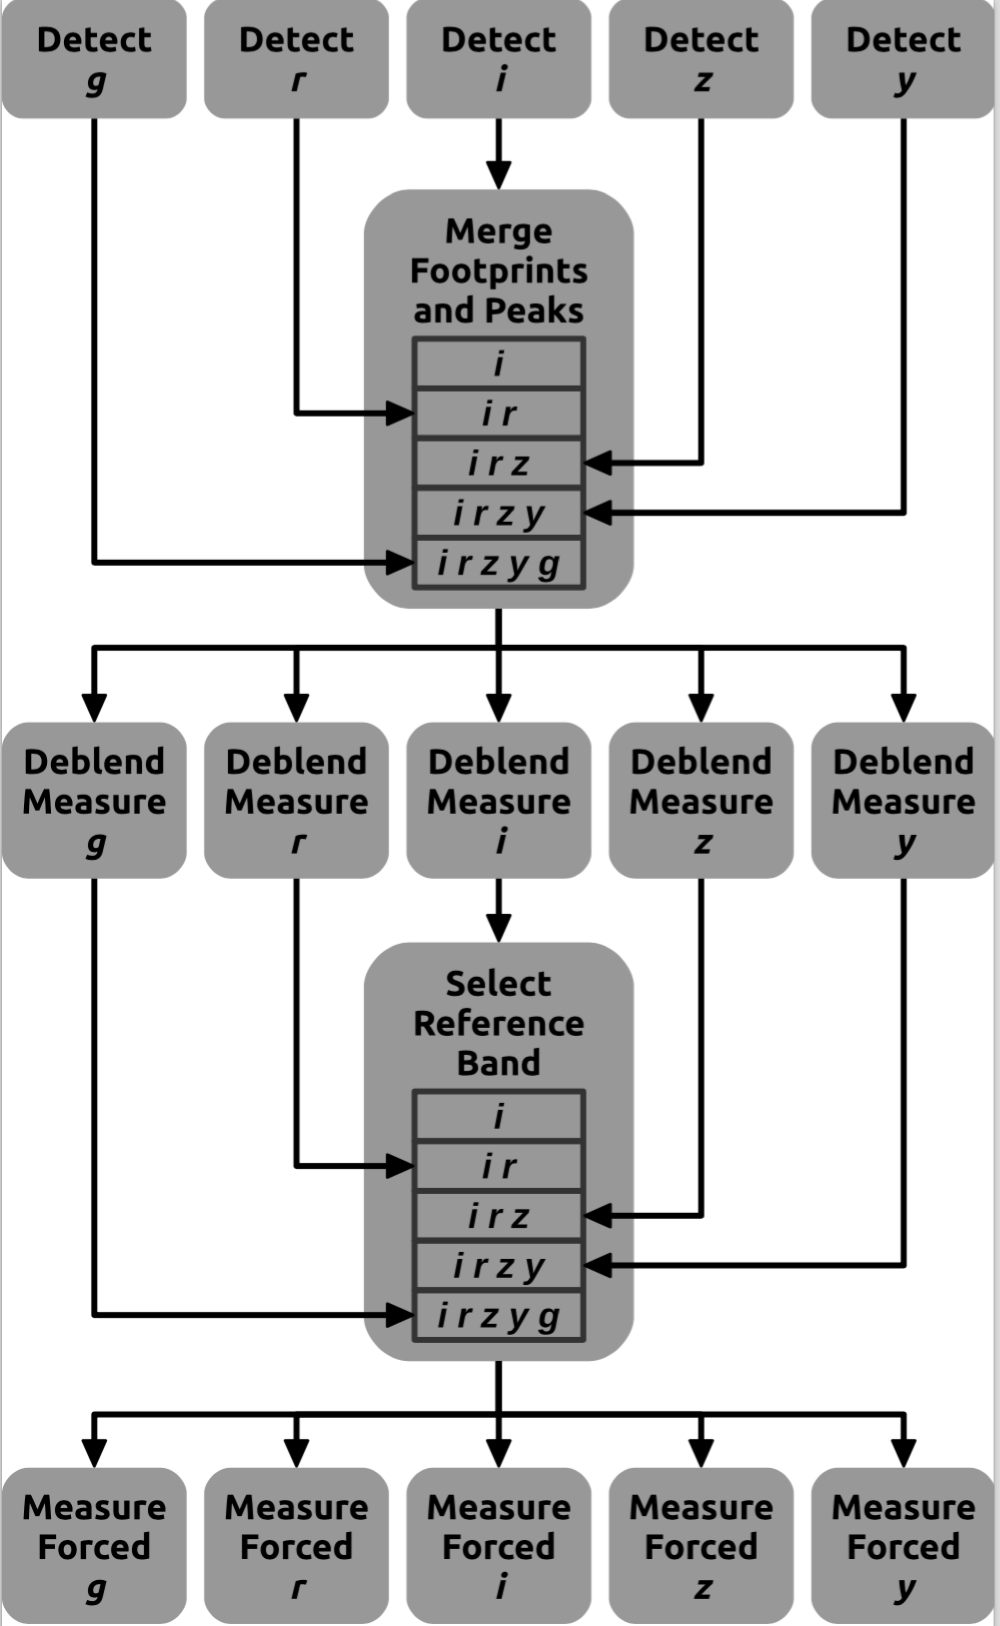

In [10]:
from IPython.display import Image
from IPython.core.display import HTML 
Image("/project/yusra/coaddProcessing.png", width=300)

# "MultibandDriver" detects and measures source on deep coadds 
# to produce the meas, forced_src and ref tables:

## Draft RFC

The DRP team has been working on a number of post-processing tasks, where post-processing is defined as computations and translations that do not touch pixels and have catalog inputs and outputs only.  These tasks currently live in github.com/lsst-dm/qa-explorer because of the history of their development.  Tim Morton was working on QA tooling to facilitate visualizing tens of millions of rows of data and had to transform and concatenate our afwTable-based fits catalogs into pandas/dask dataframes stored in a column-base file format: parquet. We adapted these translations for more general purpose. 

We propose that the main driver task be named 	`TransformObjectCatalogsTask` and moved to lsst_distrib under pipe_tasks along with the supporting classes and functions. After this is moved we can move the star-galaxy classifier to pipe_tasks as well. 

https://github.com/lsst-dm/qa_explorer/blob/master/python/lsst/qa/explorer/parquetTable.py